In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import standings_api_calls

import plotly.express as px

In [2]:
standings = standings_api_calls.main(league='all', 
                                     csv=True,
                                     cached=False).reset_index(drop=True)

NHL
MLB
NBA
NFL


In [3]:
standings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5982 entries, 0 to 5981
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         5982 non-null   object 
 1   name         5982 non-null   object 
 2   percentage   5982 non-null   float64
 3   season_year  5982 non-null   int32  
 4   season       5982 non-null   object 
 5   league       5982 non-null   object 
dtypes: float64(1), int32(1), object(4)
memory usage: 257.2+ KB


In [4]:
standings.loc[:, 'season_order'] = np.NaN
standings.loc[standings['league'] == 'NHL', 'season_order'] = 0
standings.loc[standings['league'] == 'NBA', 'season_order'] = 1
standings.loc[standings['league'] == 'MLB', 'season_order'] = 2
standings.loc[standings['league'] == 'NFL', 'season_order'] = 3

standings.loc[:, 'chart_position'] = standings['season_year'] + standings['season_order']*.25
standings = standings.sort_values('chart_position').reset_index(drop=True)

In [5]:
standings['z_score'] = standings.groupby(['league', 'season_year'])['percentage'].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
exclusions = standings.groupby(['city_group', 'season_year'])['name'].count().reset_index()
retain = exclusions.loc[exclusions['name'] > 1]

In [7]:
retain

,city,season_year,name
0,Atlanta,1969,2
1,Atlanta,1970,3
2,Atlanta,1971,3
3,Atlanta,1972,3
4,Atlanta,1973,4
...,...,...,...
2390,Washington,2020,4
2391,Washington,2021,4
2392,Washington,2022,4
2393,Washington,2023,4


In [ ]:
standings = standings[
    (standings['city_group'].isin(retain['city_group'])) &
    (standings['season_year'].isin(retain['season_year']))
    ]

In [9]:
standings

,city,name,percentage,season_year,season,league,season_order,chart_position,z_score
0,Montreal,Canadiens,0.677632,1969,19681969,NHL,0.0,1969.00,1.490827
1,Minnesota,North Stars,0.335526,1969,19681969,NHL,0.0,1969.00,-1.380395
2,Pittsburgh,Penguins,0.335526,1969,19681969,NHL,0.0,1969.00,-1.380395
3,Philadelphia,Flyers,0.401316,1969,19681969,NHL,0.0,1969.00,-0.828234
4,Bay Area,Seals,0.453947,1969,19681969,NHL,0.0,1969.00,-0.386513
...,...,...,...,...,...,...,...,...,...
5976,Houston,Texans,0.588235,2024,2024,NFL,3.0,2024.75,0.404639
5977,Baltimore,Ravens,0.705882,2024,2024,NFL,3.0,2024.75,0.944157
5978,Buffalo,Bills,0.764706,2024,2024,NFL,3.0,2024.75,1.213916
5979,New York,Giants,0.176471,2024,2024,NFL,3.0,2024.75,-1.483675


In [ ]:
standings['rolling_mean'] = standings.sort_values(by=['season_year', 'season_order']).groupby('city_group')['z_score'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()
)

In [11]:
standings.sort_values('rolling_mean', ascending=False)

,city,name,percentage,season_year,season,league,season_order,chart_position,z_score,rolling_mean
435,South Florida,Dolphins,0.785714,1974,1974,NFL,3.0,1974.75,1.516002,1.630843
49,Baltimore,Orioles,0.672840,1969,1969,MLB,2.0,1969.50,1.870111,1.576510
95,Baltimore,Orioles,0.666667,1970,1970,MLB,2.0,1970.50,2.140754,1.551729
361,South Florida,Dolphins,0.857143,1973,1973,NFL,3.0,1973.75,1.539849,1.536499
274,South Florida,Dolphins,1.000000,1972,1972,NFL,3.0,1972.75,2.117105,1.535382
...,...,...,...,...,...,...,...,...,...,...
5443,Detroit,Tigers,0.396552,2020,2020,MLB,2.0,2020.50,-1.111539,-1.766773
744,New Jersey,Nets,0.293000,1978,1977-78,NBA,1.0,1978.25,-1.858510,-1.858510
610,Tampa Bay,Buccaneers,0.000000,1976,1976,NFL,3.0,1976.75,-1.918804,-1.918804
22,Phoenix,Suns,0.195000,1969,1968-69,NBA,1.0,1969.25,-2.005398,-2.005398


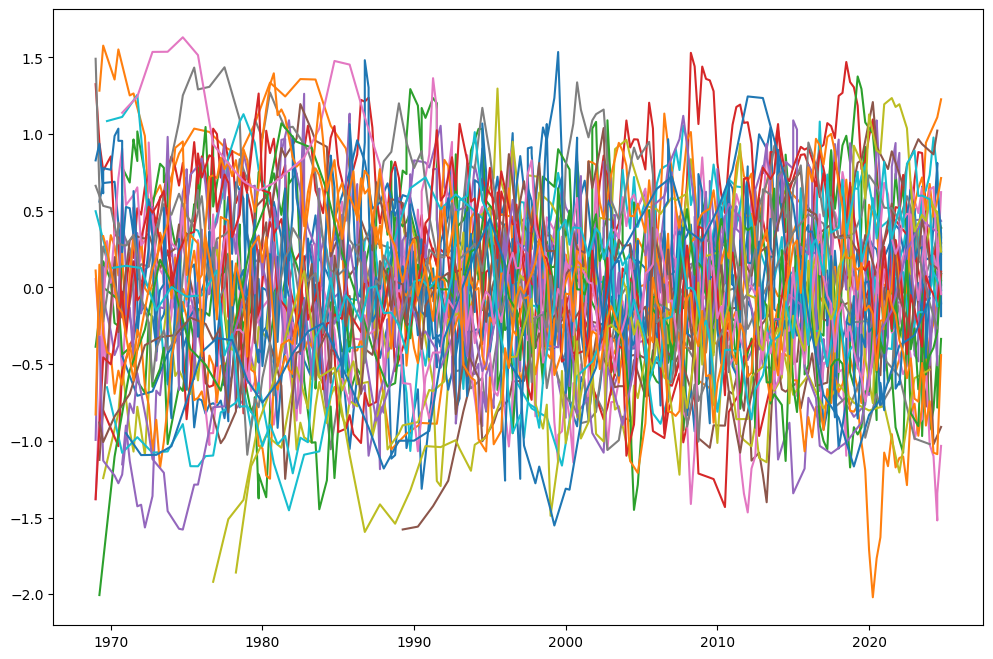

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

count = 0
for key, group in standings.groupby('city_group'):
    ax.plot(group['chart_position'], group['rolling_mean'], label=key)

In [13]:
grouped_standings = standings.groupby(['season_year', 'city'])['z_score'].agg(
    ['sum', 'mean', 'count']
    ).reset_index()

In [14]:
grouped_standings

,season_year,city,sum,mean,count
0,1969,Atlanta,1.361146,0.680573,2
1,1969,Baltimore,3.153021,1.576510,2
2,1969,Bay Area,0.683061,0.170765,4
3,1969,Boston,2.285657,0.761886,3
4,1969,Chicago,-2.440299,-0.488060,5
...,...,...,...,...,...
1744,2024,St. Louis,0.246539,0.123269,2
1745,2024,Tampa Bay,0.751348,0.250449,3
1746,2024,Toronto,-1.098853,-0.366284,3
1747,2024,Vancouver,1.050756,1.050756,1


In [15]:
grouped_standings.sort_values('sum', ascending=False)

,season_year,city,sum,mean,count
340,1980,Philadelphia,5.584138,1.396035,4
1528,2018,Boston,5.355384,1.338846,4
1411,2014,Los Angeles,5.344258,0.890710,6
601,1989,Bay Area,5.172179,1.293045,4
1240,2009,Boston,5.115761,1.278940,4
...,...,...,...,...,...
291,1979,Bay Area,-5.230938,-1.046188,5
1317,2011,Minnesota,-5.372812,-1.343203,4
773,1994,Los Angeles,-5.606285,-0.700786,8
1723,2024,Chicago,-6.313254,-1.262651,5


In [16]:
overall_standings = standings.groupby('city')['z_score'].agg(
    ['sum', 'mean', 'count']
    ).reset_index()

In [17]:
overall_standings.sort_values('mean')

,city,sum,mean,count
30,Vancouver,-22.436411,-0.380278,59
24,San Diego,-37.021481,-0.330549,112
28,Tampa Bay,-32.212448,-0.301051,107
5,Carolina,-23.962576,-0.266251,90
8,Cleveland,-38.457630,-0.234498,164
18,New Jersey,-16.418649,-0.216035,76
19,New Orleans,-17.929939,-0.216023,83
22,Phoenix,-23.727789,-0.161414,147
11,Detroit,-31.632266,-0.141849,223
13,Kansas City,-12.766754,-0.101323,126


In [18]:
fig = px.line(standings, 
              x = 'chart_position', 
              y = 'rolling_mean', 
              color = 'city', 
              line_group = 'city', 
              hover_name = 'city',
              template='plotly_dark')

In [19]:
fig.show()